# SUP ML 2 - MODEL

# Libraries

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import pickle
# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from scipy import stats 
from scipy.stats import randint as sp_randint

# Modelizacion
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
import lightgbm as lgb
# Evaluacion
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer,roc_auc_score,accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_val_score
from sklearn import metrics
from xgboost import plot_tree
import shap
from scipy.stats import pearsonr

from sklearn.model_selection import RandomizedSearchCV

pd.set_option('display.max_columns',None)

import warnings
warnings.filterwarnings("ignore")

# Carga clean data

In [64]:
df = pd.read_csv('.\\data\\df_clean.csv')

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89872 entries, 0 to 89871
Columns: 177 entries, rev to creditcd_desconocido
dtypes: bool(144), float64(28), int64(5)
memory usage: 35.0 MB


# Split X-y

In [66]:
#Dividimos el split X-y

target = 'churn'
features = df.columns[df.columns != target]

In [67]:
target

'churn'

In [68]:
X = df[features]
y = df[target]

# Distribución del target

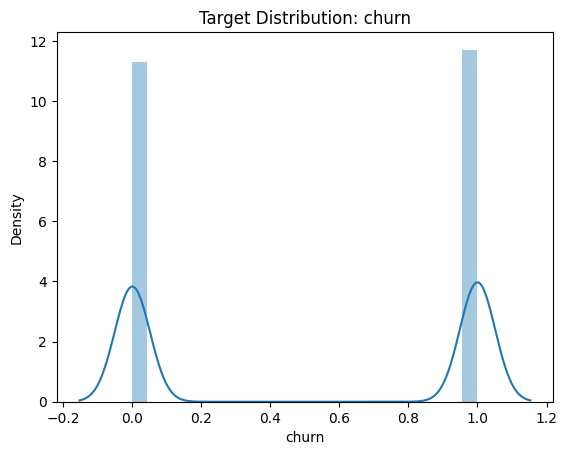

In [69]:
sns.distplot(y)
plt.title('Target Distribution: '+target)
plt.show()

# Undersampling (*)

**NOTA:** SOLO EN CLASIFICACIÓN cuando el ratio de éxitos está MUY DESBALANCEADO (<10%).

In [70]:
df["churn"].value_counts()

churn
1    45750
0    44122
Name: count, dtype: int64

# Split TRAIN-TEST

In [71]:
# Divide X-y en Train (80%) y Test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [72]:
X_train.shape

(71897, 176)

In [73]:
y_train

81484    1
37660    1
40044    1
33555    0
77134    1
        ..
6265     0
54886    1
76820    1
860      0
15795    1
Name: churn, Length: 71897, dtype: int64

In [74]:
print('Train set size:',X_train.shape[0])
print('Test set size:',X_test.shape[0])

Train set size: 71897
Test set size: 17975


# Rescaling

* NO NECESARIO en modelos de Arboles de Decisión.
* Guardar scaler en el model path.

In [75]:
scaler = StandardScaler()

X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

X_train_std = pd.DataFrame(X_train_std, columns = X_train.columns, index= X_train.index)
X_test_std = pd.DataFrame(X_test_std, columns = X_test.columns, index= X_test.index)

In [76]:
# Comentado para no ejecutarlo cada vez que relancemos el codigo

# pickle.dump(scaler, open('my_scaler.pkl', 'wb'))

In [77]:
#X_train_std.to_csv(".\\model\\X_train_std.csv")
#X_test_std.to_csv(".\\model\\X_test_std.csv")

# TRAIN-VALIDA

## Torneo de Modelos

* Probamos una colección de modelos con el objetivo de conseguir el mejor rendimiento del modelo en los datos de VALIDACION.

In [78]:
# Calculo del AUC de un modelo sobre un dataset (X-y). Args: modelo a validar, X, y
def auc(model,X,y):
  model.fit(X,y)
  return roc_auc_score(y,model.predict_proba(X)[:,1])  

# Calculo del AUC de un modelo sobre un dataset con Cross-Validation (X-y). Args: modelo a validar, X, y  
def auc_cross_validation(model,X,y):
  cross_val = cross_val_score(model, 
                              X, y, 
                              cv=4,                 # Numero de folds que vamos a utilizar para validar 
                              scoring='roc_auc'     # La metrica de validacion que se medira en cada train-valida
                              )    
  return cross_val.mean()

In [79]:
# Inicializa resultados
label_, auc_train_ , auc_valida_ = [], [], []

# Completa un registro en dataframe con los resultados de las funciones definidas previsamente ( AUC y AUC con cross-validation)

# Inputs: 
#   * modelo
#   * (X,y) 
#   * label especifico si queremos registrar el resultado con otro nombre (opcional)


def evaluate_classification(model, X, y, label=None):
  if label is None:
    label=str(model)
  label_.append(label)
  
  auc_train = auc(model,X,y)
  auc_valida = auc_cross_validation(model,X,y)   
  auc_train_.append(auc_train)
  auc_valida_.append(auc_valida)

  return pd.DataFrame({'Model': label_,
                      'AUC Train': auc_train_,
                      'AUC Cross-Valida': auc_valida_
                      }).sort_values('AUC Cross-Valida',ascending=False)

In [80]:
#Modelos a usar

    # LogisticRegression(),
    # AdaBoostClassifier(),
    # Ridge(),
    # RandomForestClassifier(),
    # XGBClassifier(),
    # GradientBoostingClassifier(),
    # DecisionTreeClassifier(),
    # BaggingClassifier(),
    # RandomForestClassifier()
    # LGBMClassifier()


In [81]:
evaluate_classification(model = AdaBoostClassifier(), 
                        X = X_train, 
                        y = y_train)

,Model,AUC Train,AUC Cross-Valida
0,AdaBoostClassifier(),0.662604,0.657027


In [82]:
evaluate_classification(model = LogisticRegression(), 
                        X = X_train_std, 
                        y = y_train)

,Model,AUC Train,AUC Cross-Valida
0,AdaBoostClassifier(),0.662604,0.657027
1,LogisticRegression(),0.625942,0.619838


In [83]:
evaluate_classification(model = BaggingClassifier(), X=X_train, y=y_train)

,Model,AUC Train,AUC Cross-Valida
0,AdaBoostClassifier(),0.662604,0.657027
1,LogisticRegression(),0.625942,0.619838
2,BaggingClassifier(),0.998944,0.618535


In [84]:
evaluate_classification(model = GradientBoostingClassifier(), X=X_train, y=y_train)

,Model,AUC Train,AUC Cross-Valida
3,GradientBoostingClassifier(),0.686684,0.670665
0,AdaBoostClassifier(),0.662604,0.657027
1,LogisticRegression(),0.625942,0.619838
2,BaggingClassifier(),0.998944,0.618535


In [85]:
evaluate_classification(model = RandomForestClassifier(), X=X_train, y=y_train)

,Model,AUC Train,AUC Cross-Valida
3,GradientBoostingClassifier(),0.686684,0.670665
0,AdaBoostClassifier(),0.662604,0.657027
4,RandomForestClassifier(),1.000000,0.655103
1,LogisticRegression(),0.625942,0.619838
2,BaggingClassifier(),0.998944,0.618535


In [86]:
evaluate_classification(model = XGBClassifier(), 
                        X=X_train, y=y_train)

,Model,AUC Train,AUC Cross-Valida
3,GradientBoostingClassifier(),0.686684,0.670665
5,"XGBClassifier(base_score=None, booster=None, c...",0.828971,0.667360
0,AdaBoostClassifier(),0.662604,0.657027
4,RandomForestClassifier(),1.000000,0.655103
1,LogisticRegression(),0.625942,0.619838
2,BaggingClassifier(),0.998944,0.618535


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
evaluate_classification(model = KNeighborsClassifier(),
                        X=X_train, y=y_train)

In [87]:
evaluate_classification(model = lgb.LGBMClassifier(), 
                        X=X_train, y=y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 36562, number of negative: 35335
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004039 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5357
[LightGBM] [Info] Number of data points in the train set: 71897, number of used features: 154
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508533 -> initscore=0.034135
[LightGBM] [Info] Start training from score 0.034135
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 27421, number of negative: 26501
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003001 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_co

,Model,AUC Train,AUC Cross-Valida
6,LGBMClassifier(),0.740851,0.679953
3,GradientBoostingClassifier(),0.686684,0.670665
5,"XGBClassifier(base_score=None, booster=None, c...",0.828971,0.667360
0,AdaBoostClassifier(),0.662604,0.657027
4,RandomForestClassifier(),1.000000,0.655103
1,LogisticRegression(),0.625942,0.619838
2,BaggingClassifier(),0.998944,0.618535


USAREMOS LGBM YA QUE ES EL QUE MAYOR AUC NOS HA DADO EN VALIDACIÓN Y EL QUE A SU VEZ MAS SE APROXIMA AL ENTRENAMIENTO

* Utilizar RandomSearch para probar diferentes configuraciones de los parametros del modelo ganador en el torneo de modelos con el objetivo de mejorar el control del overfitting.

In [88]:
parametros_hp = {
    'num_leaves': sp_randint(6, 50),
    'min_child_samples': sp_randint(10, 50),
    'min_child_weight': [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10],
    'reg_lambda': [0, 1e-1, 1, 5, 10, 20]
}

In [89]:
search_hp = RandomizedSearchCV(estimator = lgb.LGBMClassifier(), 
                               param_distributions = parametros_hp,
                               scoring = 'roc_auc',                         # metrica a optimizar: AUC
                               cv = 4,                                      # numero de folds para cross-validation
                               n_iter = 100,                                 # numero de iteraciones, cada una testeara una configuracion distinta
                               n_jobs=-1, 
                               verbose=True)

In [90]:
search_hp.fit(X_train, y_train)

Fitting 4 folds for each of 100 candidates, totalling 400 fits


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 36562, number of negative: 35335
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006131 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5353
[LightGBM] [Info] Number of data points in the train set: 71897, number of used features: 152
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508533 -> initscore=0.034135
[LightGBM] [Info] Start training from score 0.034135


RandomizedSearchCV(cv=4, estimator=LGBMClassifier(), n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.8, 0.9, 1.0],
                                        'min_child_samples': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000020164260F90>,
                                        'min_child_weight': [0.001, 0.01, 0.1,
                                                             1, 10.0, 100.0,
                                                             1000.0],
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000020164DE5450>,
                                        'reg_alpha': [0, 0.1, 1, 2, 5, 7, 10],
                                        'reg_lambda': [0, 0.1, 1, 5, 10, 20],
                                        'subsample': [0.8, 0.9, 1.0]},
                   scoring='roc_auc', verbose=True)

In [91]:
print("---- Results from Random Search -----")
print("\n The best estimator across ALL searched params:", search_hp.best_estimator_)
print("\n The best AUC:", search_hp.best_score_)
print("\n The best parameters across ALL searched params:\n", search_hp.best_params_)

---- Results from Random Search -----

 The best estimator across ALL searched params: LGBMClassifier(colsample_bytree=0.9, min_child_samples=23,
               min_child_weight=0.01, num_leaves=48, reg_alpha=7,
               reg_lambda=0.1)

 The best AUC: 0.6838429986078461

 The best parameters across ALL searched params:
 {'colsample_bytree': 0.9, 'min_child_samples': 23, 'min_child_weight': 0.01, 'num_leaves': 48, 'reg_alpha': 7, 'reg_lambda': 0.1, 'subsample': 1.0}


## Modelo final

* Entrenar el modelo final con el algoritmo y los parametros que hanfuncionado mejor en anteriores experimentos.
* Argumentar la elección.
* Guardar el modelo en model path.

In [92]:
best_model = search_hp.best_estimator_

In [93]:
print('AUC Train:', auc(best_model, X_train, y_train))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 36562, number of negative: 35335
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003814 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5353
[LightGBM] [Info] Number of data points in the train set: 71897, number of used features: 152
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508533 -> initscore=0.034135
[LightGBM] [Info] Start training from score 0.034135
AUC Train: 0.7516708258952015


In [94]:
print('AUC CV:', auc_cross_validation(best_model, X_train, y_train))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 27421, number of negative: 26501
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5300
[LightGBM] [Info] Number of data points in the train set: 53922, number of used features: 152
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508531 -> initscore=0.034127
[LightGBM] [Info] Start training from score 0.034127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 27421, number of negative: 26502
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003099 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5298
[LightGBM] [Info

In [95]:
y_train_pred = best_model.predict(X_train)              # predicciones del modelo en los datos de TRAIN
y_test_pred = best_model.predict(X_test)                # predicciones del modelo en los datos de TEST

In [96]:
#Igual que con el Scaler, lo comentamos para que no lo este generando de nuevo cada vez

#pickle.dump(best_model, open('my_model.pkl', 'wb'))

# TEST

* Evaluación de las métricas de performance en TEST.

In [97]:
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_pred)
matriz_confusion = confusion_matrix(y_test, y_test_pred)

In [98]:
# Crear un diccionario con los nombres de las métricas y sus valores
metricas_dict = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'ROC AUC': roc_auc
}

# Imprimir las métricas
for nombre_metrica, valor_metrica in metricas_dict.items():
    print(f'{nombre_metrica}: {valor_metrica:.4f}')

# Imprimir la matriz de confusión
print('\nMatriz de Confusión:')
print(matriz_confusion)

Accuracy: 0.6265
Precision: 0.6287
Recall: 0.6576
F1 Score: 0.6428
ROC AUC: 0.6258

Matriz de Confusión:
[[5219 3568]
 [3146 6042]]


AUC Train: 0.7517
AUC Test: 0.6819


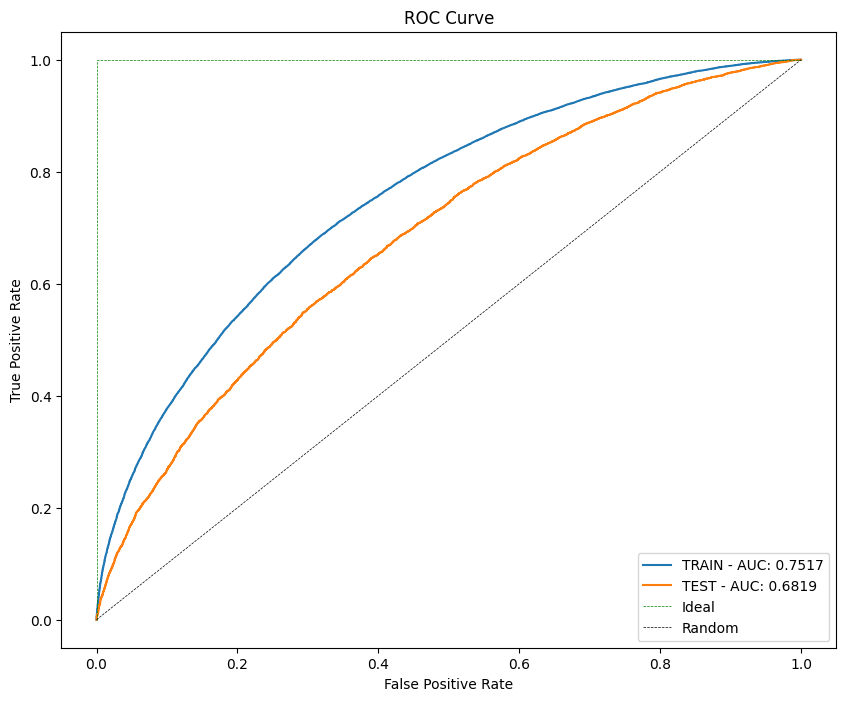

Accuracy: 0.6265
Precision: 0.6287
Recall: 0.6576
F1-score: 0.6428


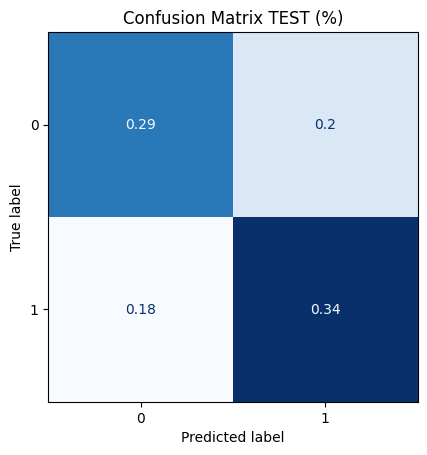

In [110]:
y_train_pred = best_model.predict(X_train)              # predicciones del modelo en los datos de TRAIN
y_test_pred = best_model.predict(X_test)                # predicciones del modelo en los datos de TEST
y_train_pred_proba = best_model.predict_proba(X_train)[:, 1]      # probabilidad de éxito (1) segun el modelo en los datos de TRAIN
y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]        # probabilidad de éxito (1) segun el modelo en los datos de TEST
######## AUC #########
from sklearn.metrics import roc_auc_score
auc_train = roc_auc_score(y_train, y_train_pred_proba)      # AUC en TRAIN
auc_test = roc_auc_score(y_test, y_test_pred_proba)         # AUC en TEST
print('AUC Train:', round(auc_train,4))
print('AUC Test:', round(auc_test,4))
########## ROC CURVE #########
from sklearn.metrics import roc_curve
# metrics for ROC
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)
#Plot
plt.figure(figsize=[10,8])
plt.plot(fpr_train, tpr_train, label='TRAIN - AUC: {:.4f}'.format(auc_train))
plt.plot(fpr_test, tpr_test, label='TEST - AUC: {:.4f}'.format(auc_test))
plt.title('ROC Curve')
plt.plot([0,0,1],[0,1,1], color='green', linestyle='--', linewidth=0.5, label='Ideal')
plt.plot([0, 1], [0, 1], color='black', linestyle='--', linewidth=0.5, label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()
########## CONFUSION MATRIX ##########
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm_test = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay(confusion_matrix=cm_test/len(y_test)).plot(colorbar = False, cmap = 'Blues')
plt.title('Confusion Matrix TEST (%)')
plt.plot()
########## Accuracy, Precision, Recall y F1-Score ##########
cm_test
TN = cm_test[0,0]
TP = cm_test[1,1]
FP = cm_test[0,1]
FN = cm_test[1,0]
total = len(y_test)
# Rellenar
accuracy_test = (TN+TP)/total
precision_test = TP/(TP+FP)
recall_test = TP/(TP+FN)
f1_test = 2/(1/recall_test + 1/precision_test)
print('Accuracy:',round(accuracy_test,4))
print('Precision:',round(precision_test,4))
print('Recall:',round(recall_test,4))
print('F1-score:',round(f1_test,4))

# INTERPRETABILITY

* Analizamos top features del modelo y su peso en el modelo.
* Plotear SHAP values y el impacto positivo/negativo.
* Comentar las top5 features, su impacto en el target y extraer insights.
* Analisis complementarios:
  * Modelos de arboles: Feature Importances, plot de arbol de decision.
  * Modelos lineales: Coeficentes y formula del modelo.

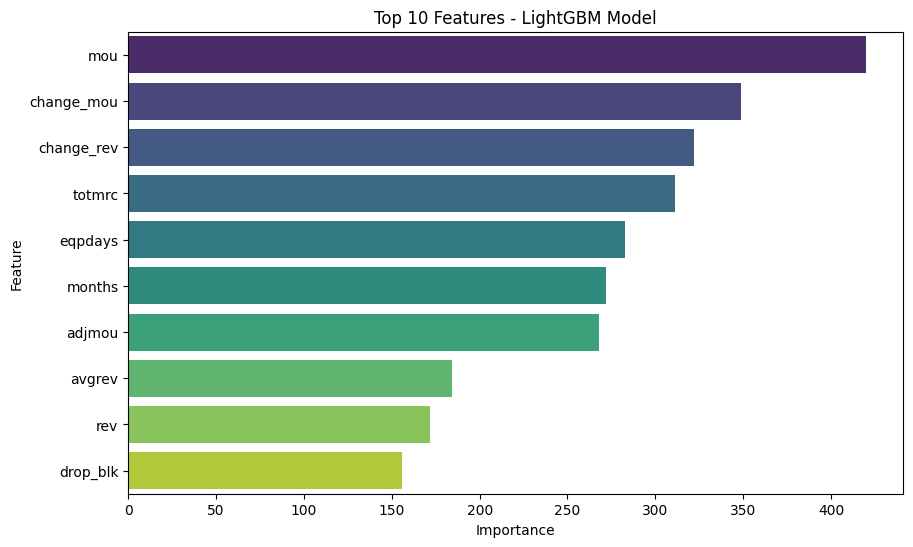

In [99]:
# Obtener las importancias de las características
feature_importance = best_model.feature_importances_

# Obtener nombres de las características
feature_names = best_model.feature_name_

# Crear un DataFrame para facilitar la manipulación de datos
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Ordenar el DataFrame por importancia en orden descendente
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Obtener las "top features" (por ejemplo, las 10 principales)
top_features = feature_importance_df.head(10)

# Visualizar las top features en un gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')
plt.title('Top 10 Features - LightGBM Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


Las 5 top features son mou, change_mou , change_rev , totmrc , eqpdays

    - mou : Numero medio de minutos mensuales de uso
    - change_mou : Cambio porcentual de uso de los ultimos tres meses
    - change_rev : Cambio porcentual en los ingresos mensuales respecto a los ultimos tres meses
    - totmrc : Media total de cargas recurrente mensual
    - eqpdays : Numero de dias del equipo actual

Tanto mou como change_mou indican el uso y el cambio respectivo que hacen del servicio, por tanto, a mayor uso es menos probable que se vayan y a menor uso, al reves
eqpdays indica el envejecimiento del equipo en uso, cuanto más viejo, es mas probable que se vayan (por ejemplo otra empresa le ofrece un equipo nuevo)
El cambio de los ingresos, va relacionado con el uso del equipo y del servicio, cuanto menos se obtiene de dicho cliente, menos esta usando el servicio y mas probable es que se marche
La media de cargas también va directamente relacionado con el uso del servicio

En general, a menor uso, menos ingresos, mayor correlación de que el cliente se marche (churn = 0)

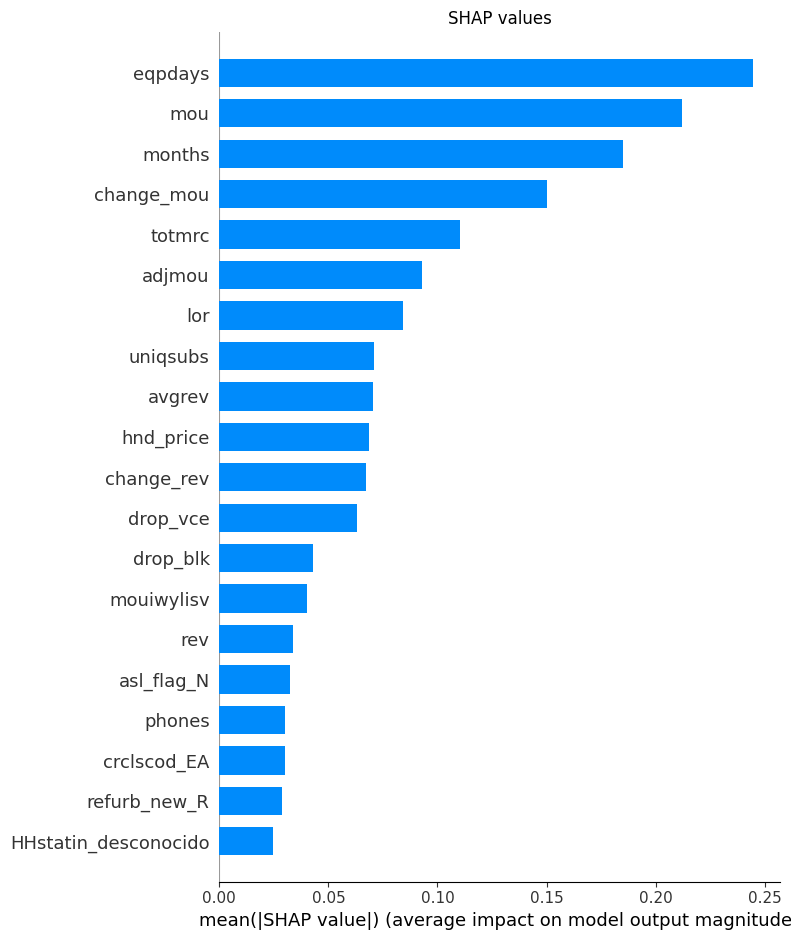

In [100]:
#SHAP value: peso en el output final
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)
plt.title('SHAP values')
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=20)

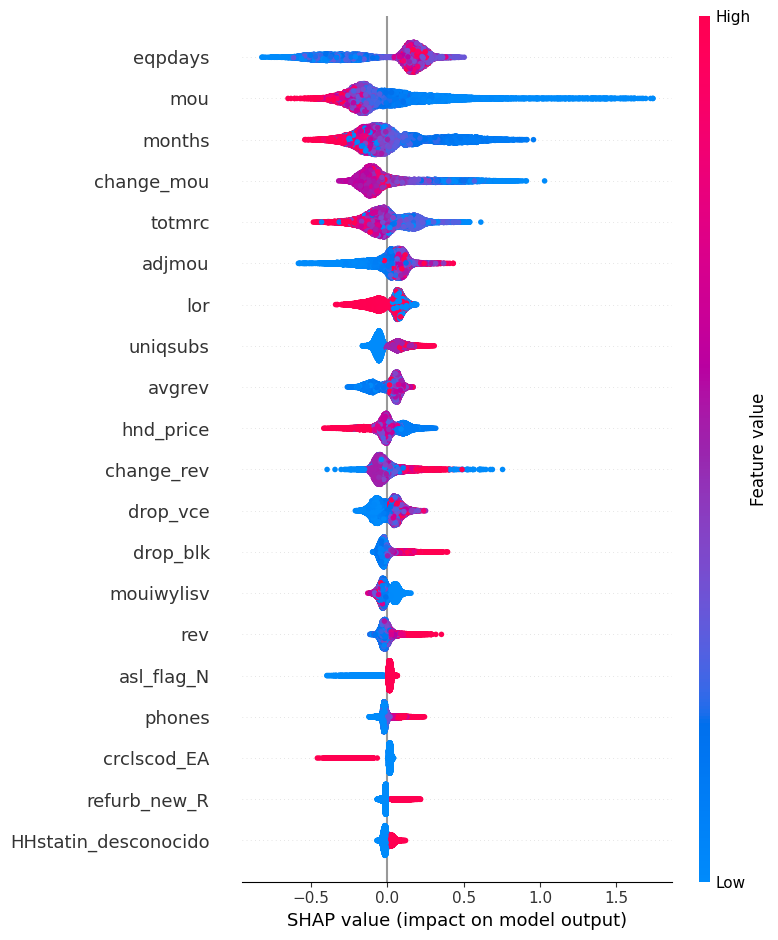

In [101]:
shap.summary_plot(shap_values, X_test)